20newsgroups data fetched from sklearn for clustering or classification task

In [17]:
import pandas as pd
import numpy as np
import sklearn
import sklearn.ensemble
from sklearn.utils import shuffle
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from io import StringIO
import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer

from sklearn.datasets import fetch_20newsgroups

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from text_prepare import html_docode, clean_text, stemm_text, lemmatize_text

newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
test = fetch_20newsgroups(subset='test',remove=('headers', 'footers', 'quotes'))

In [18]:
html_decoded = html_docode(newsgroups_train.data)
cleaned_news = clean_text(html_decoded)
stemmed_news = stemm_text(cleaned_news)
lemmatized_news = lemmatize_text(cleaned_news)

html_decoded_test = clean_text(test.data)
cleaned_test = clean_text(html_decoded_test)
stemmed_test = stemm_text(cleaned_test)
lemmatized_test = lemmatize_text(cleaned_test)

In [19]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=42,
                          max_iter=5, tol=None)),
])

text_clf.fit(lemmatized_news, newsgroups_train.target)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                ('clf',
                 SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                      

In [20]:
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1e-2, 1e-3),
}
gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)
gs_clf = gs_clf.fit(lemmatized_news, newsgroups_train.target)

In [21]:
gs_clf.best_score_

0.7410288138589358

In [22]:
predicted = text_clf.predict(cleaned_test)
np.mean(predicted == test.target)

0.6581253319171535

In [23]:
predicted = gs_clf.predict(cleaned_test)
np.mean(predicted == test.target)

0.6594530005310675

In [24]:
def show_top10(classifier, vectorizer, categories):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.coef_[i])[-10:]
        print("%s: %s" % (category, " ".join(feature_names[top10])))

show_top10(text_clf['clf'], text_clf['vect'], newsgroups_train.target_names)

alt.atheism: sank beauchaine bobbe viceicotekcom motto deletion islam bobby atheist atheism
comp.graphics: viewer pov animation format cview tiff polygon graphic 3d image
comp.os.ms-windows.misc: w4wg win3 ftpcicaindianaedu file driver cica font 31 maxaxaxaxaxaxaxaxaxaxaxaxaxaxax window
comp.sys.ibm.pc.hardware: dma jumper irq scsi2 vlb scsi bus isa controller ide
comp.sys.mac.hardware: vram nubus simms se duo centris lc quadra apple mac
comp.windows.x: colormap mit openwindows xlib client xterm x11r5 server motif widget
misc.forsale: excellent manual includes sell obo asking condition shipping offer sale
rec.autos: auto gt engine saturn wagon toyota convertible dealer ford car
rec.motorcycles: bmw harley dog rider riding helmet ride dod motorcycle bike
rec.sport.baseball: alomar phillies sox hit hitter cub brave pitcher baseball pitching
rec.sport.hockey: espn detroit player game goal leaf team nhl playoff hockey
sci.crypt: encrypted privacy chip secure crypto escrow nsa clipper encry

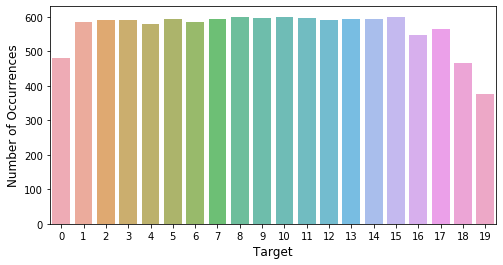

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
df_dict = {'data' : newsgroups_train.data, 'target' : newsgroups_train.target}
df_news_train =pd.DataFrame(df_dict)
count_target = df_news_train['target'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(count_target.index, count_target.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Target', fontsize=12);

In [37]:
df_news_train.head()

,data,target
0,I was wondering if anyone out there could enli...,7
1,A fair number of brave souls who upgraded thei...,4
2,"well folks, my mac plus finally gave up the gh...",4
3,\nDo you have Weitek's address/phone number? ...,1
4,"From article <C5owCB.n3p@world.std.com>, by to...",14
